In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import tree
from sklearn.tree.export import export_text
import graphviz
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

#train_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
#test_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')

#train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
#test_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#Change to run on local computer 7/28/2020 START USAMA#
train_transaction = pd.read_csv('ieee-fraud-detection/train_transaction.csv')
test_transaction = pd.read_csv('ieee-fraud-detection/test_transaction.csv')

train_identity = pd.read_csv('ieee-fraud-detection/train_identity.csv')
test_identity = pd.read_csv('ieee-fraud-detection/test_identity.csv')
#Change to run on local computer 7/28/2020 END USAMA#

C:\Users\usama\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 394)
test_transaction shape is (506691, 393)
train_identity shape is (144233, 41)
test_identity shape is (141907, 41)


In [3]:
print(np.sum(train_transaction['TransactionID'].isin(train_identity['TransactionID'].unique())))
print(np.sum(test_transaction['TransactionID'].isin(test_identity['TransactionID'].unique())))

144233
141907


In [4]:
import matplotlib.pylab as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

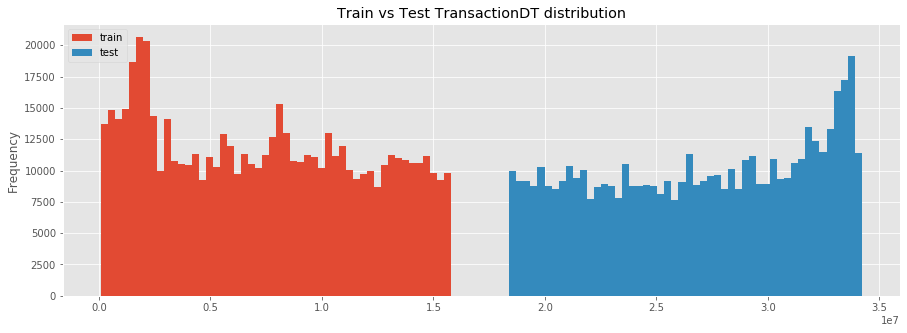

In [5]:
train_transaction['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test_transaction['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

In [6]:
print(test_transaction.head())

   TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0        3663549       18403224           31.95         W  10409  111.0   
1        3663550       18403263           49.00         W   4272  111.0   
2        3663551       18403310          171.00         W   4476  574.0   
3        3663552       18403310          284.95         W  10989  360.0   
4        3663553       18403317           67.95         W  18018  452.0   

   card3       card4  card5  card6  ...  V330  V331  V332  V333 V334 V335  \
0  150.0        visa  226.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   
1  150.0        visa  226.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   
2  150.0        visa  226.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   
3  150.0        visa  166.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   
4  150.0  mastercard  117.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   

   V336  V337  V338  V339  
0   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN  
2 

In [7]:
print(train_transaction.head())

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN  

In [8]:
print(train_transaction['isFraud'].mean() * 100)
print("Fraud %")


3.4990009144173126
Fraud %


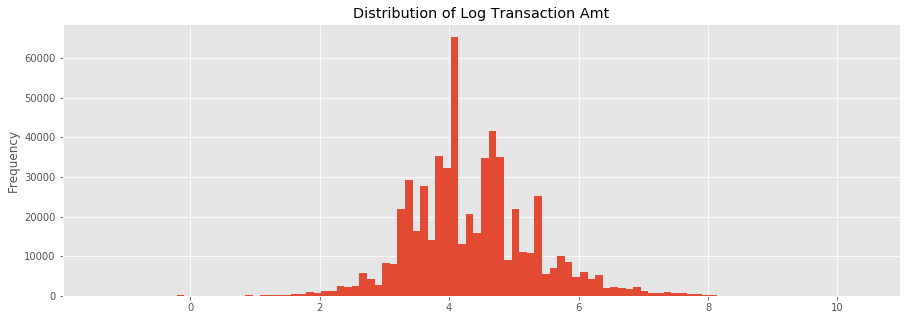

In [9]:
train_transaction['TransactionAmt'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          figsize=(15, 5),
          title='Distribution of Log Transaction Amt')
plt.show()

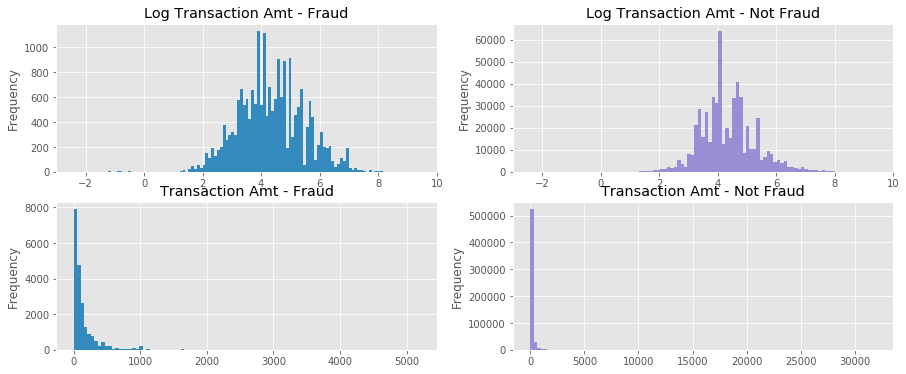

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
train_transaction.loc[train_transaction['isFraud'] == 1] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Fraud',
          color=color_pal[1],
          xlim=(-3, 10),
         ax= ax1)
train_transaction.loc[train_transaction['isFraud'] == 0] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Not Fraud',
          color=color_pal[2],
          xlim=(-3, 10),
         ax=ax2)
train_transaction.loc[train_transaction['isFraud'] == 1] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Fraud',
          color=color_pal[1],
         ax= ax3)
train_transaction.loc[train_transaction['isFraud'] == 0] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Not Fraud',
          color=color_pal[2],
         ax=ax4)
plt.show()

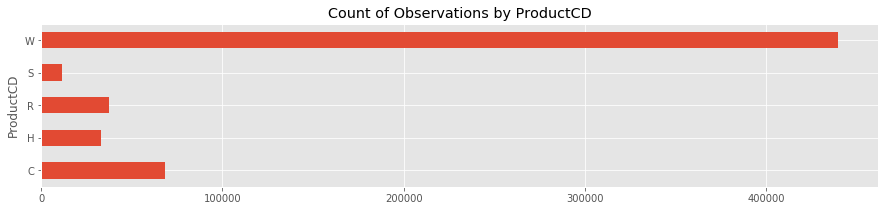

In [11]:
train_transaction.groupby('ProductCD') \
    ['TransactionID'].count() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Count of Observations by ProductCD')
plt.show()

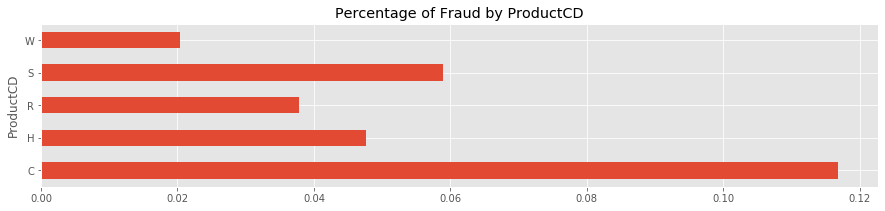

In [12]:
train_transaction.groupby('ProductCD')['isFraud'] \
    .mean() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Percentage of Fraud by ProductCD')
plt.show()

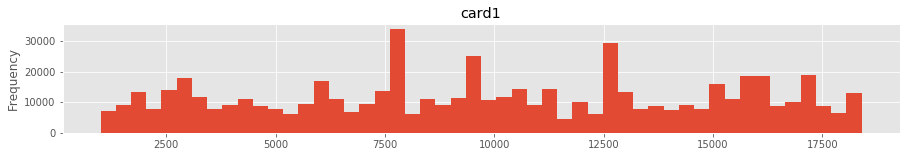

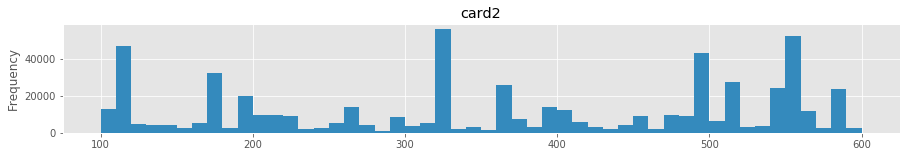

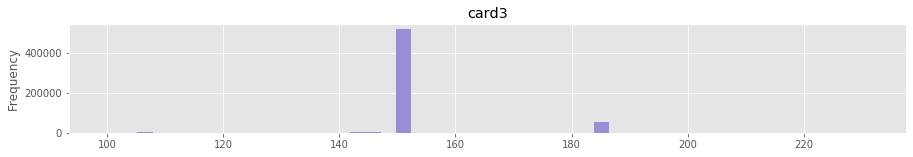

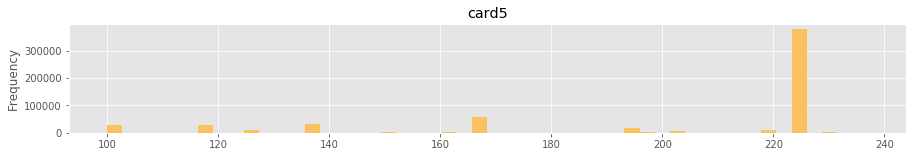

In [13]:
card_cols = [c for c in train_transaction.columns if 'card' in c]

color_idx = 0
for c in card_cols:
    if train_transaction[c].dtype in ['float64','int64']:
        train_transaction[c].plot(kind='hist',
                                      title=c,
                                      bins=50,
                                      figsize=(15, 2),
                                      color=color_pal[color_idx])
    color_idx += 1
    plt.show()

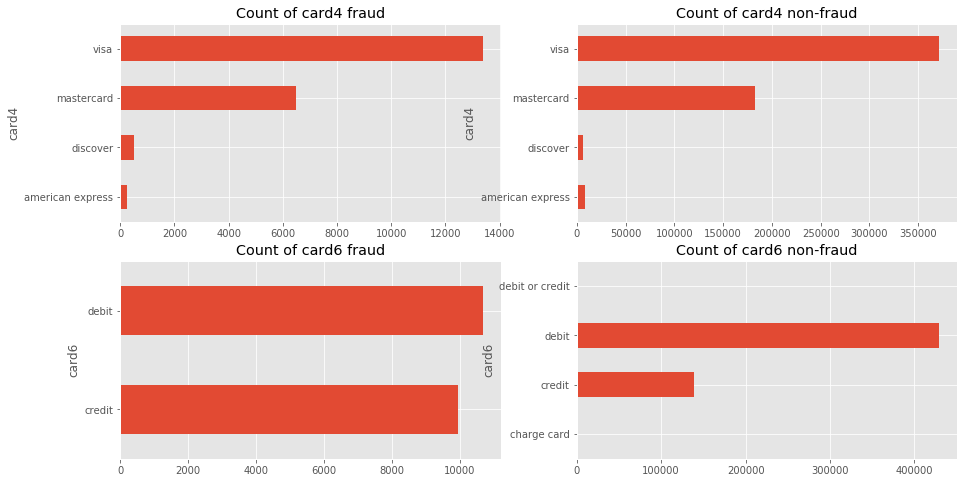

In [14]:
train_transaction_fr = train_transaction.loc[train_transaction['isFraud'] == 1]
train_transaction_nofr = train_transaction.loc[train_transaction['isFraud'] == 0]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))
train_transaction_fr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax1, title='Count of card4 fraud')
train_transaction_nofr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax2, title='Count of card4 non-fraud')
train_transaction_fr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax3, title='Count of card6 fraud')
train_transaction_nofr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax4, title='Count of card6 non-fraud')
plt.show()

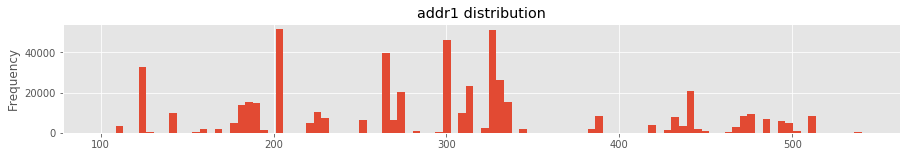

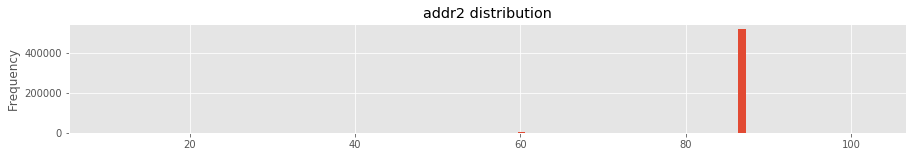

In [15]:
train_transaction['addr1'].plot(kind='hist', bins=100, figsize=(15, 2), title='addr1 distribution')
plt.show()
train_transaction['addr2'].plot(kind='hist', bins=100, figsize=(15, 2), title='addr2 distribution')
plt.show()

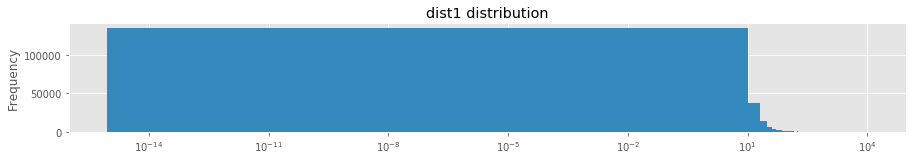

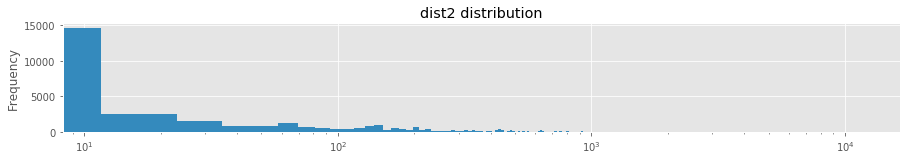

In [16]:
train_transaction['dist1'].plot(kind='hist',
                                bins=1000,
                                figsize=(15, 2),
                                title='dist1 distribution',
                                color=color_pal[1],
                                logx=True)
plt.show()
train_transaction['dist2'].plot(kind='hist',
                                bins=1000,
                                figsize=(15, 2),
                                title='dist2 distribution',
                                color=color_pal[1],
                                logx=True)
plt.show()

In [17]:
list(train_transaction.dtypes)

[dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('O'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('f

In [18]:
list(train_transaction.select_dtypes(include=['int64', 'float64']).columns)

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'card1',
 'card2',
 'card3',
 'card5',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',


In [19]:
print("----------------------------------")
print(train_transaction.describe())
print(train_transaction.info())
print("----------------------------------")
print(train_identity.describe())
print(train_identity.info())
print("----------------------------------")

----------------------------------
       TransactionID        isFraud  TransactionDT  TransactionAmt  \
count   5.905400e+05  590540.000000   5.905400e+05   590540.000000   
mean    3.282270e+06       0.034990   7.372311e+06      135.027176   
std     1.704744e+05       0.183755   4.617224e+06      239.162522   
min     2.987000e+06       0.000000   8.640000e+04        0.251000   
25%     3.134635e+06       0.000000   3.027058e+06       43.321000   
50%     3.282270e+06       0.000000   7.306528e+06       68.769000   
75%     3.429904e+06       0.000000   1.124662e+07      125.000000   
max     3.577539e+06       1.000000   1.581113e+07    31937.391000   

               card1          card2          card3          card5  \
count  590540.000000  581607.000000  588975.000000  586281.000000   
mean     9898.734658     362.555488     153.194925     199.278897   
std      4901.170153     157.793246      11.336444      41.244453   
min      1000.000000     100.000000     100.000000     100

In [20]:
train_trans_no_of_null_values = train_transaction.isna().sum()
print(train_trans_no_of_null_values)

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
V335              508189
V336              508189
V337              508189
V338              508189
V339              508189
Length: 394, dtype: int64


In [21]:
train_identity_no_of_null_values = train_identity.isna().sum()
print(train_identity_no_of_null_values)

TransactionID         0
id_01                 0
id_02              3361
id_03             77909
id_04             77909
id_05              7368
id_06              7368
id_07            139078
id_08            139078
id_09             69307
id_10             69307
id_11              3255
id_12                 0
id_13             16913
id_14             64189
id_15              3248
id_16             14893
id_17              4864
id_18             99120
id_19              4915
id_20              4972
id_21            139074
id_22            139064
id_23            139064
id_24            139486
id_25            139101
id_26            139070
id_27            139064
id_28              3255
id_29              3255
id_30             66668
id_31              3951
id_32             66647
id_33             70944
id_34             66428
id_35              3248
id_36              3248
id_37              3248
id_38              3248
DeviceType         3423
DeviceInfo        25567
dtype: int64


In [22]:
no_of_rows = train_transaction['TransactionID'].count()
print(no_of_rows)

590540


In [23]:
per_of_null_values_per_col = (train_trans_no_of_null_values / no_of_rows) * 100

In [24]:
print(list(per_of_null_values_per_col))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5126833068039423, 0.26501168422122123, 0.267043722694483, 0.7212043214684865, 0.26602770345785215, 11.12642666034477, 11.12642666034477, 59.6523520845328, 93.62837403054831, 15.99485216920107, 76.75161716395164, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21488806854743114, 47.54919226470688, 44.514850814508755, 28.60466691502693, 52.4674027161581, 87.60676668811597, 93.40992989467267, 87.31229044603245, 87.31229044603245, 12.873302401192129, 47.29349409015477, 89.04104717715988, 89.50926270870728, 89.46946862193924, 15.09008703898127, 45.90713584177194, 45.90713584177194, 45.90713584177194, 47.658753005723575, 59.34940901547736, 28.678836319300977, 58.63531682866528, 58.633115453652586, 58.633115453652586, 47.29349409015477, 47.29349409015477, 47.29349409015477, 47.29349409015477, 47.29349409015477, 47.29349409015477, 47.29349409015477, 47.29349409015477, 47.29349409015477, 47.29349409015477, 47.29349409015477, 12.8819385647

In [25]:
per_of_null_values_per_col_2 = (train_identity_no_of_null_values / no_of_rows) * 100

In [26]:
print(list(per_of_null_values_per_col_2))

[0.0, 0.0, 0.5691401090527315, 13.192840451112541, 13.192840451112541, 1.247671622582721, 1.247671622582721, 23.550987232024926, 23.550987232024926, 11.736207538862736, 11.736207538862736, 0.5511904358722526, 0.0, 2.863988891523013, 10.869543130016595, 0.5500050800961832, 2.5219290818572833, 0.8236529278287669, 16.78463778914214, 0.8322890913401293, 0.8419412740881227, 23.550309885867172, 23.548616520472788, 23.548616520472788, 23.620076540115825, 23.554881972432014, 23.54963253970942, 23.548616520472788, 0.5511904358722526, 0.5511904358722526, 11.289328411284586, 0.6690486673214346, 11.28577234395638, 12.013411453923528, 11.248687641819352, 0.5500050800961832, 0.5500050800961832, 0.5500050800961832, 0.5500050800961832, 0.5796389744979172, 4.3294273038236195]


In [27]:
##remove columns which have 90% null values
print(list(train_transaction.columns))

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V

In [28]:
print(list(train_identity.columns))

['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


In [29]:
print(type(per_of_null_values_per_col))
print(per_of_null_values_per_col.max())

<class 'pandas.core.series.Series'>
93.62837403054831


In [30]:
print(per_of_null_values_per_col[per_of_null_values_per_col >= 90])
col_list_to_drop = dict(per_of_null_values_per_col[per_of_null_values_per_col >= 90]).keys()
print(col_list_to_drop)

dist2    93.628374
D7       93.409930
dtype: float64
dict_keys(['dist2', 'D7'])


In [31]:
train_transaction.drop(col_list_to_drop,axis = 1,inplace = True)


In [32]:
print(list(train_transaction.columns))

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V8

In [33]:
print(train_transaction['card2'].isna().sum())
#first null values column

8933


In [34]:
train_transaction['card2'].fillna(train_transaction['card2'].mean(),inplace=True)
print(train_transaction['card2'].isna().sum())

0


In [35]:
print(train_transaction['card2'])

0         362.555488
1         404.000000
2         490.000000
3         567.000000
4         514.000000
             ...    
590535    362.555488
590536    225.000000
590537    595.000000
590538    481.000000
590539    170.000000
Name: card2, Length: 590540, dtype: float64


In [36]:
print(train_transaction['card3'].isna().sum())

1565


In [37]:
train_transaction['card3'].fillna(train_transaction['card3'].mean(),inplace=True)
print(train_transaction['card3'].isna().sum())

0


In [38]:
print(train_transaction['card4'].isna().sum())
print(train_transaction['card4'].value_counts(dropna=False))

1577
visa                384767
mastercard          189217
american express      8328
discover              6651
NaN                   1577
Name: card4, dtype: int64


In [39]:
train_transaction['card4'].fillna(train_transaction['card4'].mode()[0],inplace=True)
print(train_transaction['card4'].isna().sum())
print(train_transaction['card4'].value_counts(dropna=False))

0
visa                386344
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64


In [40]:
print(train_transaction['card5'].isna().sum())

4259


In [41]:
train_transaction['card5'].fillna(train_transaction['card5'].mean(),inplace=True)
print(train_transaction['card5'].isna().sum())

0


In [42]:
print(train_transaction['card6'].isna().sum())
train_transaction['card6'].fillna(train_transaction['card6'].mode()[0],inplace=True)
print(train_transaction['card6'].isna().sum())
print(train_transaction['card6'].value_counts(dropna=False))

1571
0
debit              441509
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64


In [43]:
print(train_transaction['addr1'].isna().sum())
print(train_transaction['addr2'].isna().sum())
print(train_transaction['dist1'].isna().sum())

65706
65706
352271


In [44]:
print('--------------------------------------------------------------')
print(train_transaction['addr1'].value_counts(dropna=False),end='\n')
print('--------------------------------------------------------------')
print(train_transaction['addr2'].value_counts(dropna=False),end='\n')
print('--------------------------------------------------------------')
print(train_transaction['dist1'].value_counts(dropna=False),end='\n')
print('--------------------------------------------------------------')

--------------------------------------------------------------
NaN      65706
299.0    46335
325.0    42751
204.0    42020
264.0    39870
         ...  
238.0        1
338.0        1
241.0        1
243.0        1
353.0        1
Name: addr1, Length: 333, dtype: int64
--------------------------------------------------------------
87.0    520481
NaN      65706
60.0      3084
96.0       638
32.0        91
         ...  
22.0         1
25.0         1
75.0         1
49.0         1
77.0         1
Name: addr2, Length: 75, dtype: int64
--------------------------------------------------------------
NaN       352271
0.0        19824
1.0        18330
2.0        17028
4.0        13067
           ...  
2621.0         1
2618.0         1
2613.0         1
2648.0         1
1633.0         1
Name: dist1, Length: 2652, dtype: int64
--------------------------------------------------------------


In [45]:
col_list = ['addr1','addr2','dist1']

for i in col_list:
    print(train_transaction[i].isna().sum())
    train_transaction[i].fillna(train_transaction[i].mean(),inplace=True)
    print(train_transaction[i].isna().sum())

65706
0
65706
0
352271
0


In [46]:
print('-----------------------------------------------------------')
print(train_transaction['P_emaildomain'].value_counts(dropna=False),end='\n')
print('-----------------------------------------------------------')
print(train_transaction['R_emaildomain'].value_counts(dropna=False),end='\n')
print('-----------------------------------------------------------')

-----------------------------------------------------------
gmail.com           228355
yahoo.com           100934
NaN                  94456
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
roadrunner.com         305
hotmail.es             305
windstream.net         305
hotmail.fr             295
frontier.com          

In [47]:
#making a new category of email_not_provided for both P_emaildomain,R_emaildomain
email_not_provided = 'email_not_provided'
train_transaction['P_emaildomain'].fillna(email_not_provided,inplace=True)
print(train_transaction['P_emaildomain'].isna().sum())
train_transaction['R_emaildomain'].fillna(email_not_provided,inplace=True)


0


In [48]:
print(train_transaction['R_emaildomain'].value_counts())

email_not_provided    453249
gmail.com              57147
hotmail.com            27509
anonymous.com          20529
yahoo.com              11842
                       ...  
frontiernet.net           14
netzero.com               14
centurylink.net           12
netzero.net                9
sc.rr.com                  8
Name: R_emaildomain, Length: 61, dtype: int64


In [49]:
for i in range(1,15):
    print(train_transaction['C'+str(i)].isna().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [50]:
#D7 is deleted cuz of 90% null values
for i in range(1,7):
    print(train_transaction['D'+str(i)].value_counts(dropna=False))
for i in range(8,16):
    print(train_transaction['D'+str(i)].value_counts(dropna=False))

0.0      280130
1.0        8634
2.0        4969
3.0        3954
4.0        3570
          ...  
621.0       109
619.0       107
638.0        79
639.0        42
640.0        14
Name: D1, Length: 642, dtype: int64
NaN      280797
0.0       15124
1.0        6654
2.0        4454
3.0        3677
          ...  
618.0       100
619.0        97
638.0        42
639.0        36
640.0        14
Name: D2, Length: 642, dtype: int64
NaN      262878
0.0       73094
1.0       21258
2.0       13789
7.0       13320
          ...  
630.0         1
634.0         1
638.0         1
639.0         1
590.0         1
Name: D3, Length: 650, dtype: int64
NaN      168922
0.0      166571
1.0        5315
2.0        3385
3.0        2572
          ...  
765.0         1
772.0         1
714.0         1
761.0         1
833.0         1
Name: D4, Length: 809, dtype: int64
NaN      309841
0.0       65377
1.0       15282
2.0       10244
7.0        9734
          ...  
801.0         1
671.0         1
669.0         1
643.0   

In [51]:
#D7 is deleted cuz of 90% null values
for i in range(1,7):
    print(train_transaction['D'+str(i)].isna().sum())
for i in range(8,16):
    print(train_transaction['D'+str(i)].isna().sum())

1269
280797
262878
168922
309841
517353
515614
515614
76022
279287
525823
528588
528353
89113


In [52]:
#D7 is deleted cuz of 90% null values
for i in range(1,7):
    print(train_transaction['D'+str(i)].isna().sum())
    train_transaction['D'+str(i)].fillna(train_transaction['D'+str(i)].mean(),inplace=True)
    print(train_transaction['D'+str(i)].isna().sum())
    
for i in range(8,16):
    print(train_transaction['D'+str(i)].isna().sum())
    train_transaction['D'+str(i)].fillna(train_transaction['D'+str(i)].mean(),inplace=True)
    print(train_transaction['D'+str(i)].isna().sum())

1269
0
280797
0
262878
0
168922
0
309841
0
517353
0
515614
0
515614
0
76022
0
279287
0
525823
0
528588
0
528353
0
89113
0


In [53]:
for i in range(1,10):
    print(train_transaction['M'+str(i)].value_counts(dropna=False))

T      319415
NaN    271100
F          25
Name: M1, dtype: int64
T      285468
NaN    271100
F       33972
Name: M2, dtype: int64
NaN    271100
T      251731
F       67709
Name: M3, dtype: int64
NaN    281444
M0     196405
M2      59865
M1      52826
Name: M4, dtype: int64
NaN    350482
F      132491
T      107567
Name: M5, dtype: int64
F      227856
T      193324
NaN    169360
Name: M6, dtype: int64
NaN    346265
F      211374
T       32901
Name: M7, dtype: int64
NaN    346252
F      155251
T       89037
Name: M8, dtype: int64
NaN    346252
T      205656
F       38632
Name: M9, dtype: int64


In [54]:
for i in range(1,10):
    print(train_transaction['M'+str(i)].isna().sum())
    train_transaction['M'+str(i)].fillna(train_transaction['M'+str(i)].mode()[0],inplace=True)
    print(train_transaction['M'+str(i)].isna().sum())

271100
0
271100
0
271100
0
281444
0
350482
0
169360
0
346265
0
346252
0
346252
0


In [55]:
for i in range(1,340):
    print('V' + str(i) + '   ' + str(train_transaction['V'+str(i)].isna().sum()))

V1   279287
V2   279287
V3   279287
V4   279287
V5   279287
V6   279287
V7   279287
V8   279287
V9   279287
V10   279287
V11   279287
V12   76073
V13   76073
V14   76073
V15   76073
V16   76073
V17   76073
V18   76073
V19   76073
V20   76073
V21   76073
V22   76073
V23   76073
V24   76073
V25   76073
V26   76073
V27   76073
V28   76073
V29   76073
V30   76073
V31   76073
V32   76073
V33   76073
V34   76073
V35   168969
V36   168969
V37   168969
V38   168969
V39   168969
V40   168969
V41   168969
V42   168969
V43   168969
V44   168969
V45   168969
V46   168969
V47   168969
V48   168969
V49   168969
V50   168969
V51   168969
V52   168969
V53   77096
V54   77096
V55   77096
V56   77096
V57   77096
V58   77096
V59   77096
V60   77096
V61   77096
V62   77096
V63   77096
V64   77096
V65   77096
V66   77096
V67   77096
V68   77096
V69   77096
V70   77096
V71   77096
V72   77096
V73   77096
V74   77096
V75   89164
V76   89164
V77   89164
V78   89164
V79   89164
V80   89164
V81   89164
V82   89

In [56]:
for i in range(1,340):
    print('V' + str(i) + '   ' + str(train_transaction['V'+str(i)].isna().sum()))
    train_transaction['V'+str(i)].fillna(train_transaction['V'+str(i)].median(),inplace = True)
    print('V' + str(i) + '   ' + str(train_transaction['V'+str(i)].isna().sum()))

V1   279287
V1   0
V2   279287
V2   0
V3   279287
V3   0
V4   279287
V4   0
V5   279287
V5   0
V6   279287
V6   0
V7   279287
V7   0
V8   279287
V8   0
V9   279287
V9   0
V10   279287
V10   0
V11   279287
V11   0
V12   76073
V12   0
V13   76073
V13   0
V14   76073
V14   0
V15   76073
V15   0
V16   76073
V16   0
V17   76073
V17   0
V18   76073
V18   0
V19   76073
V19   0
V20   76073
V20   0
V21   76073
V21   0
V22   76073
V22   0
V23   76073
V23   0
V24   76073
V24   0
V25   76073
V25   0
V26   76073
V26   0
V27   76073
V27   0
V28   76073
V28   0
V29   76073
V29   0
V30   76073
V30   0
V31   76073
V31   0
V32   76073
V32   0
V33   76073
V33   0
V34   76073
V34   0
V35   168969
V35   0
V36   168969
V36   0
V37   168969
V37   0
V38   168969
V38   0
V39   168969
V39   0
V40   168969
V40   0
V41   168969
V41   0
V42   168969
V42   0
V43   168969
V43   0
V44   168969
V44   0
V45   168969
V45   0
V46   168969
V46   0
V47   168969
V47   0
V48   168969
V48   0
V49   168969
V49   0
V50   168969

In [57]:
print(list(train_transaction.isna().sum()))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [58]:
print(list(train_transaction.columns))

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V8

In [59]:
target_train = pd.DataFrame(train_transaction['isFraud'])

In [60]:
print(target_train)

        isFraud
0             0
1             0
2             0
3             0
4             0
...         ...
590535        0
590536        0
590537        0
590538        0
590539        0

[590540 rows x 1 columns]


In [61]:
train_transaction.drop(['isFraud'],inplace=True,axis=1)

In [62]:
print(list(train_transaction.columns))

['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 

In [63]:
col_name = 'ProductCD'
ohe = OneHotEncoder()
product_cd_encoded = ohe.fit_transform(train_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(product_cd_encoded.shape)
product_cd_encoded_df = pd.DataFrame(product_cd_encoded)
print(product_cd_encoded_df)
product_cd_encoded_df.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
product_cd_encoded_df.columns = l
print(product_cd_encoded_df)
train_transaction.reset_index(level=0,inplace=True)
train_transaction = train_transaction.merge(product_cd_encoded_df,on='index',how='inner')
train_transaction.drop(col_name,inplace=True,axis=1)
print(train_transaction.columns)

(590540, 5)
          0    1    2    3    4
0       0.0  0.0  0.0  0.0  1.0
1       0.0  0.0  0.0  0.0  1.0
2       0.0  0.0  0.0  0.0  1.0
3       0.0  0.0  0.0  0.0  1.0
4       0.0  1.0  0.0  0.0  0.0
...     ...  ...  ...  ...  ...
590535  0.0  0.0  0.0  0.0  1.0
590536  0.0  0.0  0.0  0.0  1.0
590537  0.0  0.0  0.0  0.0  1.0
590538  0.0  0.0  0.0  0.0  1.0
590539  0.0  0.0  0.0  0.0  1.0

[590540 rows x 5 columns]
         index    C    H    R    S    W
0            0  0.0  0.0  0.0  0.0  1.0
1            1  0.0  0.0  0.0  0.0  1.0
2            2  0.0  0.0  0.0  0.0  1.0
3            3  0.0  0.0  0.0  0.0  1.0
4            4  0.0  1.0  0.0  0.0  0.0
...        ...  ...  ...  ...  ...  ...
590535  590535  0.0  0.0  0.0  0.0  1.0
590536  590536  0.0  0.0  0.0  0.0  1.0
590537  590537  0.0  0.0  0.0  0.0  1.0
590538  590538  0.0  0.0  0.0  0.0  1.0
590539  590539  0.0  0.0  0.0  0.0  1.0

[590540 rows x 6 columns]
Index(['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'c

In [64]:
col_name = 'card4'
print(train_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
card4_encoded = ohe.fit_transform(train_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(card4_encoded.shape)
card4_encoded_df = pd.DataFrame(card4_encoded)
print(card4_encoded_df)
card4_encoded_df.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
card4_encoded_df.columns = l
print(card4_encoded_df)
train_transaction = train_transaction.merge(card4_encoded_df,on='index',how='inner')
train_transaction.drop(col_name,inplace=True,axis=1)
print(train_transaction.columns)

visa                386344
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64
(590540, 4)
          0    1    2    3
0       0.0  1.0  0.0  0.0
1       0.0  0.0  1.0  0.0
2       0.0  0.0  0.0  1.0
3       0.0  0.0  1.0  0.0
4       0.0  0.0  1.0  0.0
...     ...  ...  ...  ...
590535  0.0  0.0  0.0  1.0
590536  0.0  0.0  1.0  0.0
590537  0.0  0.0  1.0  0.0
590538  0.0  0.0  1.0  0.0
590539  0.0  0.0  1.0  0.0

[590540 rows x 4 columns]
         index  american express  discover  mastercard  visa
0            0               0.0       1.0         0.0   0.0
1            1               0.0       0.0         1.0   0.0
2            2               0.0       0.0         0.0   1.0
3            3               0.0       0.0         1.0   0.0
4            4               0.0       0.0         1.0   0.0
...        ...               ...       ...         ...   ...
590535  590535               0.0       0.0         0.0   1.0
590536  590536 

In [65]:
col_name = 'card6'
print(train_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
card6_encoded = ohe.fit_transform(train_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(card6_encoded.shape)
card6_encoded_df = pd.DataFrame(card6_encoded)
print(card6_encoded_df)
card6_encoded_df.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
card6_encoded_df.columns = l
print(card6_encoded_df)
train_transaction = train_transaction.merge(card6_encoded_df,on='index',how='inner')
train_transaction.drop(col_name,inplace=True,axis=1)
print(train_transaction.columns)

debit              441509
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64
(590540, 4)
          0    1    2    3
0       0.0  1.0  0.0  0.0
1       0.0  1.0  0.0  0.0
2       0.0  0.0  1.0  0.0
3       0.0  0.0  1.0  0.0
4       0.0  1.0  0.0  0.0
...     ...  ...  ...  ...
590535  0.0  0.0  1.0  0.0
590536  0.0  0.0  1.0  0.0
590537  0.0  0.0  1.0  0.0
590538  0.0  0.0  1.0  0.0
590539  0.0  1.0  0.0  0.0

[590540 rows x 4 columns]
         index  charge card  credit  debit  debit or credit
0            0          0.0     1.0    0.0              0.0
1            1          0.0     1.0    0.0              0.0
2            2          0.0     0.0    1.0              0.0
3            3          0.0     0.0    1.0              0.0
4            4          0.0     1.0    0.0              0.0
...        ...          ...     ...    ...              ...
590535  590535          0.0     0.0    1.0              0.0
590536  590536          0.0

In [66]:
train_transaction.rename(columns = {'debit or credit' : 'debit_or_credit','charge card' : 'charge_card'},inplace=True)
print(train_transaction.columns)

Index(['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'S', 'W', 'american express', 'discover', 'mastercard', 'visa',
       'charge_card', 'credit', 'debit', 'debit_or_credit'],
      dtype='object', length=402)


In [67]:
col_name = 'P_emaildomain'
print(train_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
P_emaildomain_encoded = ohe.fit_transform(train_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(P_emaildomain_encoded.shape)
P_emaildomain_encoded = pd.DataFrame(P_emaildomain_encoded)
print(P_emaildomain_encoded)
P_emaildomain_encoded.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
P_emaildomain_encoded.columns = l
print(P_emaildomain_encoded)
train_transaction = train_transaction.merge(P_emaildomain_encoded,on='index',how='inner')
train_transaction.drop(col_name,inplace=True,axis=1)
print(train_transaction.columns)

gmail.com             228355
yahoo.com             100934
email_not_provided     94456
hotmail.com            45250
anonymous.com          36998
aol.com                28289
comcast.net             7888
icloud.com              6267
outlook.com             5096
msn.com                 4092
att.net                 4033
live.com                3041
sbcglobal.net           2970
verizon.net             2705
ymail.com               2396
bellsouth.net           1909
yahoo.com.mx            1543
me.com                  1522
cox.net                 1393
optonline.net           1011
charter.net              816
live.com.mx              749
rocketmail.com           664
mail.com                 559
earthlink.net            514
gmail                    496
outlook.es               438
mac.com                  436
juno.com                 322
aim.com                  315
windstream.net           305
hotmail.es               305
roadrunner.com           305
hotmail.fr               295
frontier.com  

In [68]:
col_names = list(train_transaction.columns)
str_col_names = ','.join(col_names)
#print(str_col_names)
str_col_names = str_col_names.replace(' ','_')
#print(str_col_names)
str_col_names = str_col_names.replace('.','_')
#print(str_col_names)
col_names = str_col_names.split(',')
train_transaction.columns = col_names


In [69]:
col_name = 'R_emaildomain'
print(train_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
R_emaildomain_encoded = ohe.fit_transform(train_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(R_emaildomain_encoded.shape)
R_emaildomain_encoded = pd.DataFrame(R_emaildomain_encoded)
print(R_emaildomain_encoded)
R_emaildomain_encoded.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
R_emaildomain_encoded.columns = l
print(R_emaildomain_encoded)
train_transaction = train_transaction.merge(R_emaildomain_encoded,on='index',how='inner')
train_transaction.drop(col_name,inplace=True,axis=1)
print(train_transaction.columns)

email_not_provided    453249
gmail.com              57147
hotmail.com            27509
anonymous.com          20529
yahoo.com              11842
                       ...  
frontiernet.net           14
netzero.com               14
centurylink.net           12
netzero.net                9
sc.rr.com                  8
Name: R_emaildomain, Length: 61, dtype: int64
(590540, 61)
         0    1    2    3    4    5    6    7    8    9   ...   51   52   53  \
0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
590535  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... 

In [70]:
col_names = list(train_transaction.columns)
str_col_names = ','.join(col_names)
#print(str_col_names)
str_col_names = str_col_names.replace('.','_')
#print(str_col_names)
col_names = str_col_names.split(',')
train_transaction.columns = col_names
col_names = ""
str_col_names = ""

In [71]:
col_name = 'M1'
print(train_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
M1_encoded = ohe.fit_transform(train_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(M1_encoded.shape)
M1_encoded = pd.DataFrame(M1_encoded)
print(M1_encoded)
M1_encoded.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
M1_encoded.columns = l
print(M1_encoded)
M1_encoded.rename(columns = {'T':'T_M1','F':'F_M1'},inplace=True)
train_transaction = train_transaction.merge(M1_encoded,on='index',how='inner')
train_transaction.drop(col_name,inplace=True,axis=1)
print(train_transaction.columns)

T    590515
F        25
Name: M1, dtype: int64
(590540, 2)
          0    1
0       0.0  1.0
1       0.0  1.0
2       0.0  1.0
3       0.0  1.0
4       0.0  1.0
...     ...  ...
590535  0.0  1.0
590536  0.0  1.0
590537  0.0  1.0
590538  0.0  1.0
590539  0.0  1.0

[590540 rows x 2 columns]
         index    F    T
0            0  0.0  1.0
1            1  0.0  1.0
2            2  0.0  1.0
3            3  0.0  1.0
4            4  0.0  1.0
...        ...  ...  ...
590535  590535  0.0  1.0
590536  590536  0.0  1.0
590537  590537  0.0  1.0
590538  590538  0.0  1.0
590539  590539  0.0  1.0

[590540 rows x 3 columns]
Index(['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'yahoo_co_jp', 'yahoo_co_uk', 'yahoo_com', 'yahoo_com_mx', 'yahoo_de',
       'yahoo_es', 'yahoo_fr', 'ymail_com', 'F_M1', 'T_M1'],
      dtype='object', length=522)


In [72]:
col_name = 'M2'
print(train_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
M2_encoded = ohe.fit_transform(train_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(M2_encoded.shape)
M2_encoded = pd.DataFrame(M2_encoded)
print(M2_encoded)
M2_encoded.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
M2_encoded.columns = l
print(M2_encoded)
M2_encoded.rename(columns = {'T':'T_M2','F':'F_M2'},inplace=True)
train_transaction = train_transaction.merge(M2_encoded,on='index',how='inner')
train_transaction.drop(col_name,inplace=True,axis=1)
print(train_transaction.columns)

T    556568
F     33972
Name: M2, dtype: int64
(590540, 2)
          0    1
0       0.0  1.0
1       0.0  1.0
2       0.0  1.0
3       0.0  1.0
4       0.0  1.0
...     ...  ...
590535  0.0  1.0
590536  1.0  0.0
590537  1.0  0.0
590538  0.0  1.0
590539  1.0  0.0

[590540 rows x 2 columns]
         index    F    T
0            0  0.0  1.0
1            1  0.0  1.0
2            2  0.0  1.0
3            3  0.0  1.0
4            4  0.0  1.0
...        ...  ...  ...
590535  590535  0.0  1.0
590536  590536  1.0  0.0
590537  590537  1.0  0.0
590538  590538  0.0  1.0
590539  590539  1.0  0.0

[590540 rows x 3 columns]
Index(['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'yahoo_com', 'yahoo_com_mx', 'yahoo_de', 'yahoo_es', 'yahoo_fr',
       'ymail_com', 'F_M1', 'T_M1', 'F_M2', 'T_M2'],
      dtype='object', length=523)


In [73]:
col_name = 'M3'
print(train_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
M3_encoded = ohe.fit_transform(train_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(M3_encoded.shape)
M3_encoded = pd.DataFrame(M3_encoded)
print(M3_encoded)
M3_encoded.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
M3_encoded.columns = l
print(M3_encoded)
M3_encoded.rename(columns = {'T':'T_M3','F':'F_M3'},inplace=True)
train_transaction = train_transaction.merge(M3_encoded,on='index',how='inner')
train_transaction.drop(col_name,inplace=True,axis=1)
print(train_transaction.columns)

T    522831
F     67709
Name: M3, dtype: int64
(590540, 2)
          0    1
0       0.0  1.0
1       0.0  1.0
2       0.0  1.0
3       0.0  1.0
4       0.0  1.0
...     ...  ...
590535  0.0  1.0
590536  1.0  0.0
590537  1.0  0.0
590538  0.0  1.0
590539  1.0  0.0

[590540 rows x 2 columns]
         index    F    T
0            0  0.0  1.0
1            1  0.0  1.0
2            2  0.0  1.0
3            3  0.0  1.0
4            4  0.0  1.0
...        ...  ...  ...
590535  590535  0.0  1.0
590536  590536  1.0  0.0
590537  590537  1.0  0.0
590538  590538  0.0  1.0
590539  590539  1.0  0.0

[590540 rows x 3 columns]
Index(['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'yahoo_de', 'yahoo_es', 'yahoo_fr', 'ymail_com', 'F_M1', 'T_M1', 'F_M2',
       'T_M2', 'F_M3', 'T_M3'],
      dtype='object', length=524)


In [74]:
col_name = 'M4'
print(train_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
M4_encoded = ohe.fit_transform(train_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(M4_encoded.shape)
M4_encoded = pd.DataFrame(M4_encoded)
print(M4_encoded)
M4_encoded.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
M4_encoded.columns = l
print(M4_encoded)
M4_encoded.rename(columns = {'M0':'M0_M4','M1':'M1_M4','M2':'M2_M4'},inplace=True)
train_transaction = train_transaction.merge(M4_encoded,on='index',how='inner')
train_transaction.drop(col_name,inplace=True,axis=1)
print(train_transaction.columns)

M0    477849
M2     59865
M1     52826
Name: M4, dtype: int64
(590540, 3)
          0    1    2
0       0.0  0.0  1.0
1       1.0  0.0  0.0
2       1.0  0.0  0.0
3       1.0  0.0  0.0
4       1.0  0.0  0.0
...     ...  ...  ...
590535  1.0  0.0  0.0
590536  1.0  0.0  0.0
590537  1.0  0.0  0.0
590538  1.0  0.0  0.0
590539  1.0  0.0  0.0

[590540 rows x 3 columns]
         index   M0   M1   M2
0            0  0.0  0.0  1.0
1            1  1.0  0.0  0.0
2            2  1.0  0.0  0.0
3            3  1.0  0.0  0.0
4            4  1.0  0.0  0.0
...        ...  ...  ...  ...
590535  590535  1.0  0.0  0.0
590536  590536  1.0  0.0  0.0
590537  590537  1.0  0.0  0.0
590538  590538  1.0  0.0  0.0
590539  590539  1.0  0.0  0.0

[590540 rows x 4 columns]
Index(['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'ymail_com', 'F_M1', 'T_M1', 'F_M2', 'T_M2', 'F_M3', 'T_M3', 'M0_M4',
       'M1_M4', 'M2_M4'],
     

In [75]:
col_name = 'M5'
print(train_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
M5_encoded = ohe.fit_transform(train_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(M5_encoded.shape)
M5_encoded = pd.DataFrame(M5_encoded)
print(M5_encoded)
M5_encoded.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
M5_encoded.columns = l
print(M5_encoded)
M5_encoded.rename(columns = {'T':'T_M5','F':'F_M5'},inplace=True)
train_transaction = train_transaction.merge(M5_encoded,on='index',how='inner')
train_transaction.drop(col_name,inplace=True,axis=1)
print(train_transaction.columns)

F    482973
T    107567
Name: M5, dtype: int64
(590540, 2)
          0    1
0       1.0  0.0
1       0.0  1.0
2       1.0  0.0
3       0.0  1.0
4       1.0  0.0
...     ...  ...
590535  0.0  1.0
590536  1.0  0.0
590537  1.0  0.0
590538  1.0  0.0
590539  1.0  0.0

[590540 rows x 2 columns]
         index    F    T
0            0  1.0  0.0
1            1  0.0  1.0
2            2  1.0  0.0
3            3  0.0  1.0
4            4  1.0  0.0
...        ...  ...  ...
590535  590535  0.0  1.0
590536  590536  1.0  0.0
590537  590537  1.0  0.0
590538  590538  1.0  0.0
590539  590539  1.0  0.0

[590540 rows x 3 columns]
Index(['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'T_M1', 'F_M2', 'T_M2', 'F_M3', 'T_M3', 'M0_M4', 'M1_M4', 'M2_M4',
       'F_M5', 'T_M5'],
      dtype='object', length=527)


In [76]:
col_name = 'M6'
print(train_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
M6_encoded = ohe.fit_transform(train_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(M6_encoded.shape)
M6_encoded = pd.DataFrame(M6_encoded)
print(M6_encoded)
M6_encoded.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
M6_encoded.columns = l
print(M6_encoded)
M6_encoded.rename(columns = {'T':'T_M6','F':'F_M6'},inplace=True)
train_transaction = train_transaction.merge(M6_encoded,on='index',how='inner')
train_transaction.drop(col_name,inplace=True,axis=1)
print(train_transaction.columns)

F    397216
T    193324
Name: M6, dtype: int64
(590540, 2)
          0    1
0       0.0  1.0
1       0.0  1.0
2       1.0  0.0
3       1.0  0.0
4       1.0  0.0
...     ...  ...
590535  1.0  0.0
590536  0.0  1.0
590537  0.0  1.0
590538  0.0  1.0
590539  0.0  1.0

[590540 rows x 2 columns]
         index    F    T
0            0  0.0  1.0
1            1  0.0  1.0
2            2  1.0  0.0
3            3  1.0  0.0
4            4  1.0  0.0
...        ...  ...  ...
590535  590535  1.0  0.0
590536  590536  0.0  1.0
590537  590537  0.0  1.0
590538  590538  0.0  1.0
590539  590539  0.0  1.0

[590540 rows x 3 columns]
Index(['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'T_M2', 'F_M3', 'T_M3', 'M0_M4', 'M1_M4', 'M2_M4', 'F_M5', 'T_M5',
       'F_M6', 'T_M6'],
      dtype='object', length=528)


In [77]:
col_name = 'M7'
print(train_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
M7_encoded = ohe.fit_transform(train_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(M7_encoded.shape)
M7_encoded = pd.DataFrame(M7_encoded)
print(M7_encoded)
M7_encoded.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
M7_encoded.columns = l
print(M7_encoded)
M7_encoded.rename(columns = {'T':'T_M7','F':'F_M7'},inplace=True)
train_transaction = train_transaction.merge(M7_encoded,on='index',how='inner')
train_transaction.drop(col_name,inplace=True,axis=1)
print(train_transaction.columns)

F    557639
T     32901
Name: M7, dtype: int64
(590540, 2)
          0    1
0       1.0  0.0
1       1.0  0.0
2       1.0  0.0
3       1.0  0.0
4       1.0  0.0
...     ...  ...
590535  1.0  0.0
590536  1.0  0.0
590537  1.0  0.0
590538  1.0  0.0
590539  1.0  0.0

[590540 rows x 2 columns]
         index    F    T
0            0  1.0  0.0
1            1  1.0  0.0
2            2  1.0  0.0
3            3  1.0  0.0
4            4  1.0  0.0
...        ...  ...  ...
590535  590535  1.0  0.0
590536  590536  1.0  0.0
590537  590537  1.0  0.0
590538  590538  1.0  0.0
590539  590539  1.0  0.0

[590540 rows x 3 columns]
Index(['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'T_M3', 'M0_M4', 'M1_M4', 'M2_M4', 'F_M5', 'T_M5', 'F_M6', 'T_M6',
       'F_M7', 'T_M7'],
      dtype='object', length=529)


In [78]:
col_name = 'M8'
print(train_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
M8_encoded = ohe.fit_transform(train_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(M8_encoded.shape)
M8_encoded = pd.DataFrame(M8_encoded)
print(M8_encoded)
M8_encoded.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
M8_encoded.columns = l
print(M8_encoded)
M8_encoded.rename(columns = {'T':'T_M8','F':'F_M8'},inplace=True)
train_transaction = train_transaction.merge(M8_encoded,on='index',how='inner')
train_transaction.drop(col_name,inplace=True,axis=1)
print(train_transaction.columns)

F    501503
T     89037
Name: M8, dtype: int64
(590540, 2)
          0    1
0       1.0  0.0
1       1.0  0.0
2       1.0  0.0
3       1.0  0.0
4       1.0  0.0
...     ...  ...
590535  1.0  0.0
590536  1.0  0.0
590537  1.0  0.0
590538  1.0  0.0
590539  1.0  0.0

[590540 rows x 2 columns]
         index    F    T
0            0  1.0  0.0
1            1  1.0  0.0
2            2  1.0  0.0
3            3  1.0  0.0
4            4  1.0  0.0
...        ...  ...  ...
590535  590535  1.0  0.0
590536  590536  1.0  0.0
590537  590537  1.0  0.0
590538  590538  1.0  0.0
590539  590539  1.0  0.0

[590540 rows x 3 columns]
Index(['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'M1_M4', 'M2_M4', 'F_M5', 'T_M5', 'F_M6', 'T_M6', 'F_M7', 'T_M7',
       'F_M8', 'T_M8'],
      dtype='object', length=530)


In [79]:
col_name = 'M9'
print(train_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
M9_encoded = ohe.fit_transform(train_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(M9_encoded.shape)
M9_encoded = pd.DataFrame(M9_encoded)
print(M9_encoded)
M9_encoded.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
M9_encoded.columns = l
print(M9_encoded)
M9_encoded.rename(columns = {'T':'T_M9','F':'F_M9'},inplace=True)
train_transaction = train_transaction.merge(M9_encoded,on='index',how='inner')
train_transaction.drop(col_name,inplace=True,axis=1)
print(train_transaction.columns)

T    551908
F     38632
Name: M9, dtype: int64
(590540, 2)
          0    1
0       0.0  1.0
1       0.0  1.0
2       1.0  0.0
3       0.0  1.0
4       0.0  1.0
...     ...  ...
590535  0.0  1.0
590536  1.0  0.0
590537  0.0  1.0
590538  0.0  1.0
590539  1.0  0.0

[590540 rows x 2 columns]
         index    F    T
0            0  0.0  1.0
1            1  0.0  1.0
2            2  1.0  0.0
3            3  0.0  1.0
4            4  0.0  1.0
...        ...  ...  ...
590535  590535  0.0  1.0
590536  590536  1.0  0.0
590537  590537  0.0  1.0
590538  590538  0.0  1.0
590539  590539  1.0  0.0

[590540 rows x 3 columns]
Index(['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'F_M5', 'T_M5', 'F_M6', 'T_M6', 'F_M7', 'T_M7', 'F_M8', 'T_M8', 'F_M9',
       'T_M9'],
      dtype='object', length=531)


In [80]:
X_train = train_transaction.to_numpy()
Y_train = target_train.to_numpy()
print(X_train.shape)
print(Y_train.shape)

(590540, 531)
(590540, 1)


In [81]:
DTree = tree.DecisionTreeClassifier(random_state=0, criterion='entropy',max_depth=8,splitter='best', min_samples_split=30)
DTree = DTree.fit(X_train,Y_train)

In [82]:
DTree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [83]:
r = export_text(DTree)
print(r)

|--- feature_296 <= 1.50
|   |--- feature_332 <= 0.50
|   |   |--- feature_24 <= 0.50
|   |   |   |--- feature_11 <= 2.50
|   |   |   |   |--- feature_9 <= 86.90
|   |   |   |   |   |--- feature_388 <= 0.50
|   |   |   |   |   |   |--- feature_125 <= 1.50
|   |   |   |   |   |   |   |--- feature_27 <= 10.00
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_27 >  10.00
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_125 >  1.50
|   |   |   |   |   |   |   |--- feature_92 <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_92 >  0.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_388 >  0.50
|   |   |   |   |   |   |--- feature_411 <= 0.50
|   |   |   |   |   |   |   |--- feature_6 <= 149.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_6 >  149.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |

In [84]:
dot_data = tree.export_graphviz(DTree,out_file=None,feature_names=None,class_names=None,filled=True,rounded=True,special_characters=True)

In [85]:
graph = graphviz.Source(dot_data)

In [86]:
graph.format = 'png'

In [87]:
graph.render()

'Source.gv.png'

In [88]:
from IPython.display import Image

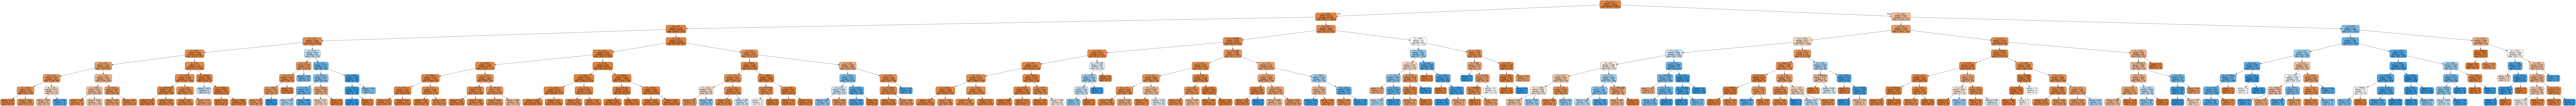

In [89]:
Image(filename='Source.gv.png',width=1000,height=300)

In [90]:
pred = DTree.predict(X_train)
print("The accuracy is: " + str(metrics.accuracy_score(Y_train,pred)))

The accuracy is: 0.9740288549463203


In [91]:
print(test_transaction.describe())
print("--------------------------------------")
print(test_transaction.info())

       TransactionID  TransactionDT  TransactionAmt          card1  \
count   5.066910e+05   5.066910e+05   506691.000000  506691.000000   
mean    3.916894e+06   2.692994e+07      134.725568    9957.222175   
std     1.462692e+05   4.756507e+06      245.779822    4884.960969   
min     3.663549e+06   1.840322e+07        0.018000    1001.000000   
25%     3.790222e+06   2.277154e+07       40.000000    6019.000000   
50%     3.916894e+06   2.720466e+07       67.950000    9803.000000   
75%     4.043566e+06   3.134856e+07      125.000000   14276.000000   
max     4.170239e+06   3.421434e+07    10270.000000   18397.000000   

               card2          card3          card5          addr1  \
count  498037.000000  503689.000000  502144.000000  441082.000000   
mean      363.735379     153.543409     200.162975     291.846514   
std       158.688653      12.443013      40.562461     102.062730   
min       100.000000     100.000000     100.000000     100.000000   
25%       207.000000    

In [92]:
print(list(test_transaction.columns))

['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83',

In [94]:
print(test_transaction.isna().sum())
print(type(test_transaction.isna().sum()))

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
                   ...  
V335              430260
V336              430260
V337              430260
V338              430260
V339              430260
Length: 393, dtype: int64
<class 'pandas.core.series.Series'>


In [95]:
total_no_of_rows = test_transaction['TransactionID'].count()
print(total_no_of_rows)
print(type(total_no_of_rows))

506691
<class 'numpy.int32'>


In [96]:
per_no_of_null_values = (test_transaction.isna().sum() / total_no_of_rows) * 100
print(per_no_of_null_values)
print(type(per_no_of_null_values))

TransactionID      0.000000
TransactionDT      0.000000
TransactionAmt     0.000000
ProductCD          0.000000
card1              0.000000
                    ...    
V335              84.915659
V336              84.915659
V337              84.915659
V338              84.915659
V339              84.915659
Length: 393, dtype: float64
<class 'pandas.core.series.Series'>


In [97]:
print(per_no_of_null_values[per_no_of_null_values >= 90])
print(type(per_no_of_null_values[per_no_of_null_values >= 90]))

dist2    92.80903
dtype: float64
<class 'pandas.core.series.Series'>


In [98]:
for i in ['dist2', 'D7']:
    test_transaction.drop(i,axis=1,inplace=True)

print(list(test_transaction.columns))

['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 

In [99]:
for i in ['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD']:
    #print(i)
    print(test_transaction[i].value_counts(dropna=False))

3663619    1
3870155    1
3882445    1
3876302    1
3878351    1
          ..
4063893    1
4070038    1
4067991    1
4090520    1
3664125    1
Name: TransactionID, Length: 506691, dtype: int64
33613413    4
26576684    4
33750653    4
19601418    4
32146010    4
           ..
27107047    1
26076904    1
32374507    1
23934706    1
22020096    1
Name: TransactionDT, Length: 494686, dtype: int64
59.00      27365
117.00     25798
107.95     20243
57.95      20063
100.00     17565
           ...  
1935.19        1
1186.53        1
676.62         1
510.58         1
271.14         1
Name: TransactionAmt, Length: 14119, dtype: int64
W    360987
C     69266
R     35647
H     29373
S     11418
Name: ProductCD, dtype: int64


In [100]:
for i in range(1,7):
    print(test_transaction['card' + str(i)].value_counts(dropna=False))

7919     13083
15885    12330
9500     12081
17188     9262
15066     6661
         ...  
1667         1
8516         1
2369         1
1754         1
18392        1
Name: card1, Length: 13244, dtype: int64
321.0    42796
555.0    38409
111.0    37346
490.0    32351
583.0    19700
         ...  
240.0       34
487.0       30
234.0       24
480.0        7
586.0        1
Name: card2, Length: 498, dtype: int64
150.0    435558
185.0     53614
NaN        3002
106.0      1972
117.0      1879
          ...  
230.0         1
174.0         1
175.0         1
183.0         1
186.0         1
Name: card3, Length: 116, dtype: int64
visa                334882
mastercard          158169
american express      7681
NaN                   3086
discover              2873
Name: card4, dtype: int64
226.0    256991
224.0     71596
166.0     45790
138.0     22102
117.0     21120
          ...  
208.0         1
125.0         1
172.0         1
167.0         1
201.0         1
Name: card5, Length: 103, dtype: int64

In [101]:
print(test_transaction['card2'].isna().sum())

8654


In [102]:
test_transaction['card2'].fillna(test_transaction['card2'].mean(),inplace=True)
print(test_transaction['card2'].isna().sum())

0


In [103]:
print(test_transaction['card3'].isna().sum())
test_transaction['card3'].fillna(test_transaction['card3'].mean(),inplace=True)
print(test_transaction['card3'].isna().sum())

3002
0


In [104]:
print(dict(test_transaction.isna().sum()))

{'TransactionID': 0, 'TransactionDT': 0, 'TransactionAmt': 0, 'ProductCD': 0, 'card1': 0, 'card2': 0, 'card3': 0, 'card4': 3086, 'card5': 4547, 'card6': 3007, 'addr1': 65609, 'addr2': 65609, 'dist1': 291217, 'P_emaildomain': 69192, 'R_emaildomain': 370821, 'C1': 3, 'C2': 3, 'C3': 3, 'C4': 3, 'C5': 3, 'C6': 3, 'C7': 3, 'C8': 3, 'C9': 3, 'C10': 3, 'C11': 3, 'C12': 3, 'C13': 4748, 'C14': 3, 'D1': 6031, 'D2': 234769, 'D3': 203142, 'D4': 76851, 'D5': 224375, 'D6': 381908, 'D8': 432353, 'D9': 432353, 'D10': 12545, 'D11': 176518, 'D12': 437437, 'D13': 383307, 'D14': 391497, 'D15': 12069, 'M1': 176639, 'M2': 176639, 'M3': 176639, 'M4': 237745, 'M5': 309632, 'M6': 158939, 'M7': 235018, 'M8': 235004, 'M9': 235004, 'V1': 176518, 'V2': 176518, 'V3': 176518, 'V4': 176518, 'V5': 176518, 'V6': 176518, 'V7': 176518, 'V8': 176518, 'V9': 176518, 'V10': 176518, 'V11': 176518, 'V12': 12589, 'V13': 12589, 'V14': 12589, 'V15': 12589, 'V16': 12589, 'V17': 12589, 'V18': 12589, 'V19': 12589, 'V20': 12589, 'V21

In [105]:
print(test_transaction['card4'].isna().sum())
print(test_transaction['card4'].value_counts(dropna=False))

3086
visa                334882
mastercard          158169
american express      7681
NaN                   3086
discover              2873
Name: card4, dtype: int64


In [106]:
test_transaction['card4'].fillna(test_transaction['card4'].mode()[0],inplace=True)
print(test_transaction['card4'].isna().sum())
print(test_transaction['card4'].value_counts(dropna=False))

0
visa                337968
mastercard          158169
american express      7681
discover              2873
Name: card4, dtype: int64


In [107]:
print(test_transaction['card5'].isna().sum())
print(test_transaction['card5'].value_counts(dropna=False))

4547
226.0    256991
224.0     71596
166.0     45790
138.0     22102
117.0     21120
          ...  
208.0         1
125.0         1
172.0         1
167.0         1
201.0         1
Name: card5, Length: 103, dtype: int64


In [108]:
test_transaction['card5'].fillna(test_transaction['card5'].mean(),inplace=True)
print(test_transaction['card5'].isna().sum())

0


In [109]:
print(test_transaction['card6'].isna().sum())
print(test_transaction['card6'].value_counts(dropna=False))

3007
debit          385021
credit         118662
NaN              3007
charge card         1
Name: card6, dtype: int64


In [110]:
print(test_transaction['card6'].isna().sum())
test_transaction['card6'].fillna(test_transaction['card6'].mode()[0],inplace=True)
print(test_transaction['card6'].isna().sum())
print(test_transaction['card6'].value_counts(dropna=False))

3007
0
debit          388028
credit         118662
charge card         1
Name: card6, dtype: int64


In [111]:
print(test_transaction['addr1'].isna().sum())
print(test_transaction['addr2'].isna().sum())
print(test_transaction['dist1'].isna().sum())

65609
65609
291217


In [112]:
print('--------------------------------------------------------------')
print(train_transaction['addr1'].value_counts(dropna=False),end='\n')
print('--------------------------------------------------------------')
print(train_transaction['addr2'].value_counts(dropna=False),end='\n')
print('--------------------------------------------------------------')
print(train_transaction['dist1'].value_counts(dropna=False),end='\n')
print('--------------------------------------------------------------')

--------------------------------------------------------------
290.733794    65706
299.000000    46335
325.000000    42751
204.000000    42020
264.000000    39870
              ...  
223.000000        1
462.000000        1
128.000000        1
481.000000        1
306.000000        1
Name: addr1, Length: 333, dtype: int64
--------------------------------------------------------------
87.00000    520481
86.80063     65706
60.00000      3084
96.00000       638
32.00000        91
             ...  
70.00000         1
55.00000         1
14.00000         1
22.00000         1
77.00000         1
Name: addr2, Length: 75, dtype: int64
--------------------------------------------------------------
118.50218     352271
0.00000        19824
1.00000        18330
2.00000        17028
4.00000        13067
               ...  
2621.00000         1
2618.00000         1
2613.00000         1
2648.00000         1
1633.00000         1
Name: dist1, Length: 2652, dtype: int64
----------------------------------

In [113]:
col_list = ['addr1','addr2','dist1']

for i in col_list:
    print(test_transaction[i].isna().sum())
    test_transaction[i].fillna(test_transaction[i].mean(),inplace=True)
    print(test_transaction[i].isna().sum())

65609
0
65609
0
291217
0


In [114]:
print('-----------------------------------------------------------')
print(test_transaction['P_emaildomain'].value_counts(dropna=False),end='\n')
print('-----------------------------------------------------------')
print(test_transaction['R_emaildomain'].value_counts(dropna=False),end='\n')
print('-----------------------------------------------------------')

-----------------------------------------------------------
gmail.com           207448
yahoo.com            81850
NaN                  69192
hotmail.com          40399
anonymous.com        34064
                     ...  
yahoo.de                63
yahoo.co.uk             54
live.fr                 50
servicios-ta.com        45
scranton.edu             2
Name: P_emaildomain, Length: 61, dtype: int64
-----------------------------------------------------------
NaN                370821
gmail.com           61738
hotmail.com         25657
anonymous.com       19115
yahoo.com            9563
                    ...  
centurylink.net        16
netzero.net            10
netzero.com            10
scranton.edu            6
sc.rr.com               6
Name: R_emaildomain, Length: 61, dtype: int64
-----------------------------------------------------------


In [115]:
#making a new category of email_not_provided for both P_emaildomain,R_emaildomain
email_not_provided = 'email_not_provided'
test_transaction['P_emaildomain'].fillna(email_not_provided,inplace=True)
print(test_transaction['P_emaildomain'].isna().sum())
test_transaction['R_emaildomain'].fillna(email_not_provided,inplace=True)

0


In [116]:
print(test_transaction['R_emaildomain'].value_counts())

email_not_provided    370821
gmail.com              61738
hotmail.com            25657
anonymous.com          19115
yahoo.com               9563
                       ...  
centurylink.net           16
netzero.com               10
netzero.net               10
sc.rr.com                  6
scranton.edu               6
Name: R_emaildomain, Length: 61, dtype: int64


In [117]:
for i in range(1,15):
    print(test_transaction['C'+str(i)].isna().sum())

3
3
3
3
3
3
3
3
3
3
3
3
4748
3


In [118]:
for i in range(1,15):
    print(test_transaction['C'+str(i)].isna().sum())
    test_transaction['C' + str(i)].fillna(test_transaction['C' + str(i)].median(),inplace=True)
    print(test_transaction['C'+str(i)].isna().sum())

3
0
3
0
3
0
3
0
3
0
3
0
3
0
3
0
3
0
3
0
3
0
3
0
4748
0
3
0


In [119]:
#D7 is deleted cuz of 90% null values
for i in range(1,7):
    print(test_transaction['D'+str(i)].value_counts(dropna=False))
for i in range(8,16):
    print(test_transaction['D'+str(i)].value_counts(dropna=False))

0.0      227724
1.0        8253
NaN        6031
2.0        5005
3.0        4084
          ...  
513.0       111
472.0       107
558.0       104
640.0        53
641.0         1
Name: D1, Length: 643, dtype: int64
NaN      234769
0.0       11944
1.0        6467
2.0        4445
3.0        3829
          ...  
529.0       105
558.0       101
472.0        98
640.0        47
641.0         1
Name: D2, Length: 643, dtype: int64
NaN      203142
0.0       73232
1.0       20276
2.0       13103
7.0       11442
          ...  
883.0         1
841.0         1
853.0         1
779.0         1
865.0         1
Name: D3, Length: 888, dtype: int64
0.0       178278
NaN        76851
1.0         5750
2.0         3502
3.0         2871
           ...  
1016.0         1
987.0          1
1034.0         1
1051.0         1
1059.0         1
Name: D4, Length: 1057, dtype: int64
NaN      224375
0.0       73887
1.0       15642
2.0       10188
7.0        9103
          ...  
958.0         1
886.0         1
967.0       

In [120]:
#D7 is deleted cuz of 90% null values
for i in range(1,7):
    print(test_transaction['D'+str(i)].isna().sum())
for i in range(8,16):
    print(test_transaction['D'+str(i)].isna().sum())

6031
234769
203142
76851
224375
381908
432353
432353
12545
176518
437437
383307
391497
12069


In [121]:
#D7 is deleted cuz of 90% null values
for i in range(1,7):
    print(test_transaction['D'+str(i)].isna().sum())
    test_transaction['D'+str(i)].fillna(test_transaction['D'+str(i)].mean(),inplace=True)
    print(test_transaction['D'+str(i)].isna().sum())
    
for i in range(8,16):
    print(test_transaction['D'+str(i)].isna().sum())
    test_transaction['D'+str(i)].fillna(test_transaction['D'+str(i)].mean(),inplace=True)
    print(test_transaction['D'+str(i)].isna().sum())

6031
0
234769
0
203142
0
76851
0
224375
0
381908
0
432353
0
432353
0
12545
0
176518
0
437437
0
383307
0
391497
0
12069
0


In [122]:
for i in range(1,10):
    print(test_transaction['M'+str(i)].value_counts(dropna=False))

T      330021
NaN    176639
F          31
Name: M1, dtype: int64
T      302855
NaN    176639
F       27197
Name: M2, dtype: int64
T      266513
NaN    176639
F       63539
Name: M3, dtype: int64
NaN    237745
M0     161384
M2      63082
M1      44480
Name: M4, dtype: int64
NaN    309632
F      107664
T       89395
Name: M5, dtype: int64
F      191577
NaN    158939
T      156175
Name: M6, dtype: int64
NaN    235018
F      233230
T       38443
Name: M7, dtype: int64
NaN    235004
F      168399
T      103288
Name: M8, dtype: int64
T      236279
NaN    235004
F       35408
Name: M9, dtype: int64


In [123]:
for i in range(1,10):
    print(test_transaction['M'+str(i)].isna().sum())
    test_transaction['M'+str(i)].fillna(test_transaction['M'+str(i)].mode()[0],inplace=True)
    print(test_transaction['M'+str(i)].isna().sum())

176639
0
176639
0
176639
0
237745
0
309632
0
158939
0
235018
0
235004
0
235004
0


In [124]:
for i in range(1,340):
    print('V' + str(i) + '   ' + str(test_transaction['V'+str(i)].isna().sum()))

V1   176518
V2   176518
V3   176518
V4   176518
V5   176518
V6   176518
V7   176518
V8   176518
V9   176518
V10   176518
V11   176518
V12   12589
V13   12589
V14   12589
V15   12589
V16   12589
V17   12589
V18   12589
V19   12589
V20   12589
V21   12589
V22   12589
V23   12589
V24   12589
V25   12589
V26   12589
V27   12589
V28   12589
V29   12589
V30   12589
V31   12589
V32   12589
V33   12589
V34   12589
V35   76854
V36   76854
V37   76854
V38   76854
V39   76854
V40   76854
V41   76854
V42   76854
V43   76854
V44   76854
V45   76854
V46   76854
V47   76854
V48   76854
V49   76854
V50   76854
V51   76854
V52   76854
V53   12899
V54   12899
V55   12899
V56   12899
V57   12899
V58   12899
V59   12899
V60   12899
V61   12899
V62   12899
V63   12899
V64   12899
V65   12899
V66   12899
V67   12899
V68   12899
V69   12899
V70   12899
V71   12899
V72   12899
V73   12899
V74   12899
V75   12081
V76   12081
V77   12081
V78   12081
V79   12081
V80   12081
V81   12081
V82   12081
V83   12081
V8

In [125]:
for i in range(1,340):
    print('V' + str(i) + '   ' + str(test_transaction['V'+str(i)].isna().sum()))
    test_transaction['V'+str(i)].fillna(test_transaction['V'+str(i)].median(),inplace = True)
    print('V' + str(i) + '   ' + str(test_transaction['V'+str(i)].isna().sum()))

V1   176518
V1   0
V2   176518
V2   0
V3   176518
V3   0
V4   176518
V4   0
V5   176518
V5   0
V6   176518
V6   0
V7   176518
V7   0
V8   176518
V8   0
V9   176518
V9   0
V10   176518
V10   0
V11   176518
V11   0
V12   12589
V12   0
V13   12589
V13   0
V14   12589
V14   0
V15   12589
V15   0
V16   12589
V16   0
V17   12589
V17   0
V18   12589
V18   0
V19   12589
V19   0
V20   12589
V20   0
V21   12589
V21   0
V22   12589
V22   0
V23   12589
V23   0
V24   12589
V24   0
V25   12589
V25   0
V26   12589
V26   0
V27   12589
V27   0
V28   12589
V28   0
V29   12589
V29   0
V30   12589
V30   0
V31   12589
V31   0
V32   12589
V32   0
V33   12589
V33   0
V34   12589
V34   0
V35   76854
V35   0
V36   76854
V36   0
V37   76854
V37   0
V38   76854
V38   0
V39   76854
V39   0
V40   76854
V40   0
V41   76854
V41   0
V42   76854
V42   0
V43   76854
V43   0
V44   76854
V44   0
V45   76854
V45   0
V46   76854
V46   0
V47   76854
V47   0
V48   76854
V48   0
V49   76854
V49   0
V50   76854
V50   0
V51   7

In [126]:
print(list(test_transaction.isna().sum()))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [127]:
print(list(test_transaction.columns))

['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 

In [128]:
target_test = pd.DataFrame(columns=['isFraud'])
print(list(target_test.columns))

['isFraud']


In [129]:
col_name = 'ProductCD'
ohe = OneHotEncoder()
product_cd_encoded = ohe.fit_transform(test_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(product_cd_encoded.shape)
product_cd_encoded_df = pd.DataFrame(product_cd_encoded)
print(product_cd_encoded_df)
product_cd_encoded_df.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
product_cd_encoded_df.columns = l
print(product_cd_encoded_df)
test_transaction.reset_index(level=0,inplace=True)
test_transaction = test_transaction.merge(product_cd_encoded_df,on='index',how='inner')
test_transaction.drop(col_name,inplace=True,axis=1)
print(test_transaction.columns)

(506691, 5)
          0    1    2    3    4
0       0.0  0.0  0.0  0.0  1.0
1       0.0  0.0  0.0  0.0  1.0
2       0.0  0.0  0.0  0.0  1.0
3       0.0  0.0  0.0  0.0  1.0
4       0.0  0.0  0.0  0.0  1.0
...     ...  ...  ...  ...  ...
506686  1.0  0.0  0.0  0.0  0.0
506687  1.0  0.0  0.0  0.0  0.0
506688  0.0  0.0  0.0  0.0  1.0
506689  0.0  0.0  0.0  0.0  1.0
506690  1.0  0.0  0.0  0.0  0.0

[506691 rows x 5 columns]
         index    C    H    R    S    W
0            0  0.0  0.0  0.0  0.0  1.0
1            1  0.0  0.0  0.0  0.0  1.0
2            2  0.0  0.0  0.0  0.0  1.0
3            3  0.0  0.0  0.0  0.0  1.0
4            4  0.0  0.0  0.0  0.0  1.0
...        ...  ...  ...  ...  ...  ...
506686  506686  1.0  0.0  0.0  0.0  0.0
506687  506687  1.0  0.0  0.0  0.0  0.0
506688  506688  0.0  0.0  0.0  0.0  1.0
506689  506689  0.0  0.0  0.0  0.0  1.0
506690  506690  1.0  0.0  0.0  0.0  0.0

[506691 rows x 6 columns]
Index(['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'c

In [130]:
col_name = 'card4'
print(test_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
card4_encoded = ohe.fit_transform(test_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(card4_encoded.shape)
card4_encoded_df = pd.DataFrame(card4_encoded)
print(card4_encoded_df)
card4_encoded_df.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
card4_encoded_df.columns = l
print(card4_encoded_df)
test_transaction = test_transaction.merge(card4_encoded_df,on='index',how='inner')
test_transaction.drop(col_name,inplace=True,axis=1)
print(test_transaction.columns)

visa                337968
mastercard          158169
american express      7681
discover              2873
Name: card4, dtype: int64
(506691, 4)
          0    1    2    3
0       0.0  0.0  0.0  1.0
1       0.0  0.0  0.0  1.0
2       0.0  0.0  0.0  1.0
3       0.0  0.0  0.0  1.0
4       0.0  0.0  1.0  0.0
...     ...  ...  ...  ...
506686  0.0  0.0  1.0  0.0
506687  0.0  0.0  1.0  0.0
506688  0.0  0.0  0.0  1.0
506689  0.0  0.0  1.0  0.0
506690  0.0  0.0  0.0  1.0

[506691 rows x 4 columns]
         index  american express  discover  mastercard  visa
0            0               0.0       0.0         0.0   1.0
1            1               0.0       0.0         0.0   1.0
2            2               0.0       0.0         0.0   1.0
3            3               0.0       0.0         0.0   1.0
4            4               0.0       0.0         1.0   0.0
...        ...               ...       ...         ...   ...
506686  506686               0.0       0.0         1.0   0.0
506687  506687 

In [131]:
col_name = 'card6'
print(test_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
card6_encoded = ohe.fit_transform(test_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(card6_encoded.shape)
card6_encoded_df = pd.DataFrame(card6_encoded)
print(card6_encoded_df)
card6_encoded_df.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
card6_encoded_df.columns = l
print(card6_encoded_df)
test_transaction = test_transaction.merge(card6_encoded_df,on='index',how='inner')
test_transaction.drop(col_name,inplace=True,axis=1)
print(test_transaction.columns)

debit          388028
credit         118662
charge card         1
Name: card6, dtype: int64
(506691, 3)
          0    1    2
0       0.0  0.0  1.0
1       0.0  0.0  1.0
2       0.0  0.0  1.0
3       0.0  0.0  1.0
4       0.0  0.0  1.0
...     ...  ...  ...
506686  0.0  0.0  1.0
506687  0.0  0.0  1.0
506688  0.0  0.0  1.0
506689  0.0  0.0  1.0
506690  0.0  1.0  0.0

[506691 rows x 3 columns]
         index  charge card  credit  debit
0            0          0.0     0.0    1.0
1            1          0.0     0.0    1.0
2            2          0.0     0.0    1.0
3            3          0.0     0.0    1.0
4            4          0.0     0.0    1.0
...        ...          ...     ...    ...
506686  506686          0.0     0.0    1.0
506687  506687          0.0     0.0    1.0
506688  506688          0.0     0.0    1.0
506689  506689          0.0     0.0    1.0
506690  506690          0.0     1.0    0.0

[506691 rows x 4 columns]
Index(['index', 'TransactionID', 'TransactionDT', 'Transaction

In [132]:
test_transaction.rename(columns = {'debit or credit' : 'debit_or_credit','charge card' : 'charge_card','american express':'american_express'},inplace=True)
print(test_transaction.columns)

Index(['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'R', 'S', 'W', 'american_express', 'discover', 'mastercard', 'visa',
       'charge_card', 'credit', 'debit'],
      dtype='object', length=401)


In [133]:
print(list(test_transaction.columns))

['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', '

In [134]:
col_name = 'P_emaildomain'
print(test_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
P_emaildomain_encoded = ohe.fit_transform(test_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(P_emaildomain_encoded.shape)
P_emaildomain_encoded = pd.DataFrame(P_emaildomain_encoded)
print(P_emaildomain_encoded)
P_emaildomain_encoded.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
P_emaildomain_encoded.columns = l
print(P_emaildomain_encoded)
test_transaction = test_transaction.merge(P_emaildomain_encoded,on='index',how='inner')
test_transaction.drop(col_name,inplace=True,axis=1)
print(test_transaction.columns)

gmail.com             207448
yahoo.com              81850
email_not_provided     69192
hotmail.com            40399
anonymous.com          34064
                       ...  
yahoo.de                  63
yahoo.co.uk               54
live.fr                   50
servicios-ta.com          45
scranton.edu               2
Name: P_emaildomain, Length: 61, dtype: int64
(506691, 61)
         0    1    2    3    4    5    6    7    8    9   ...   51   52   53  \
0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1       0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
506686  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... 

In [135]:
col_names = list(test_transaction.columns)
str_col_names = ','.join(col_names)
#print(str_col_names)
str_col_names = str_col_names.replace(' ','_')
#print(str_col_names)
str_col_names = str_col_names.replace('.','_')
#print(str_col_names)
col_names = str_col_names.split(',')
test_transaction.columns = col_names

In [136]:
col_name = 'R_emaildomain'
print(test_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
R_emaildomain_encoded = ohe.fit_transform(test_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(R_emaildomain_encoded.shape)
R_emaildomain_encoded = pd.DataFrame(R_emaildomain_encoded)
print(R_emaildomain_encoded)
R_emaildomain_encoded.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
R_emaildomain_encoded.columns = l
print(R_emaildomain_encoded)
test_transaction = test_transaction.merge(R_emaildomain_encoded,on='index',how='inner')
test_transaction.drop(col_name,inplace=True,axis=1)
print(test_transaction.columns)

email_not_provided    370821
gmail.com              61738
hotmail.com            25657
anonymous.com          19115
yahoo.com               9563
                       ...  
centurylink.net           16
netzero.com               10
netzero.net               10
sc.rr.com                  6
scranton.edu               6
Name: R_emaildomain, Length: 61, dtype: int64
(506691, 61)
         0    1    2    3    4    5    6    7    8    9   ...   51   52   53  \
0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
506686  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... 

In [137]:
col_names = list(test_transaction.columns)
str_col_names = ','.join(col_names)
#print(str_col_names)
str_col_names = str_col_names.replace('.','_')
#print(str_col_names)
col_names = str_col_names.split(',')
test_transaction.columns = col_names
col_names = ""
str_col_names = ""

In [138]:
col_name = 'M1'
print(test_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
M1_encoded = ohe.fit_transform(test_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(M1_encoded.shape)
M1_encoded = pd.DataFrame(M1_encoded)
print(M1_encoded)
M1_encoded.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
M1_encoded.columns = l
print(M1_encoded)
M1_encoded.rename(columns = {'T':'T_M1','F':'F_M1'},inplace=True)
test_transaction = test_transaction.merge(M1_encoded,on='index',how='inner')
test_transaction.drop(col_name,inplace=True,axis=1)
print(test_transaction.columns)

T    506660
F        31
Name: M1, dtype: int64
(506691, 2)
          0    1
0       0.0  1.0
1       0.0  1.0
2       0.0  1.0
3       0.0  1.0
4       0.0  1.0
...     ...  ...
506686  0.0  1.0
506687  0.0  1.0
506688  0.0  1.0
506689  0.0  1.0
506690  0.0  1.0

[506691 rows x 2 columns]
         index    F    T
0            0  0.0  1.0
1            1  0.0  1.0
2            2  0.0  1.0
3            3  0.0  1.0
4            4  0.0  1.0
...        ...  ...  ...
506686  506686  0.0  1.0
506687  506687  0.0  1.0
506688  506688  0.0  1.0
506689  506689  0.0  1.0
506690  506690  0.0  1.0

[506691 rows x 3 columns]
Index(['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'yahoo_co_jp', 'yahoo_co_uk', 'yahoo_com', 'yahoo_com_mx', 'yahoo_de',
       'yahoo_es', 'yahoo_fr', 'ymail_com', 'F_M1', 'T_M1'],
      dtype='object', length=522)


In [139]:
col_name = 'M2'
print(test_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
M2_encoded = ohe.fit_transform(test_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(M2_encoded.shape)
M2_encoded = pd.DataFrame(M2_encoded)
print(M2_encoded)
M2_encoded.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
M2_encoded.columns = l
print(M2_encoded)
M2_encoded.rename(columns = {'T':'T_M2','F':'F_M2'},inplace=True)
test_transaction = test_transaction.merge(M2_encoded,on='index',how='inner')
test_transaction.drop(col_name,inplace=True,axis=1)
print(test_transaction.columns)

T    479494
F     27197
Name: M2, dtype: int64
(506691, 2)
          0    1
0       0.0  1.0
1       1.0  0.0
2       0.0  1.0
3       0.0  1.0
4       0.0  1.0
...     ...  ...
506686  0.0  1.0
506687  0.0  1.0
506688  0.0  1.0
506689  0.0  1.0
506690  0.0  1.0

[506691 rows x 2 columns]
         index    F    T
0            0  0.0  1.0
1            1  1.0  0.0
2            2  0.0  1.0
3            3  0.0  1.0
4            4  0.0  1.0
...        ...  ...  ...
506686  506686  0.0  1.0
506687  506687  0.0  1.0
506688  506688  0.0  1.0
506689  506689  0.0  1.0
506690  506690  0.0  1.0

[506691 rows x 3 columns]
Index(['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'yahoo_com', 'yahoo_com_mx', 'yahoo_de', 'yahoo_es', 'yahoo_fr',
       'ymail_com', 'F_M1', 'T_M1', 'F_M2', 'T_M2'],
      dtype='object', length=523)


In [140]:
col_name = 'M3'
print(test_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
M3_encoded = ohe.fit_transform(test_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(M3_encoded.shape)
M3_encoded = pd.DataFrame(M3_encoded)
print(M3_encoded)
M3_encoded.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
M3_encoded.columns = l
print(M3_encoded)
M3_encoded.rename(columns = {'T':'T_M3','F':'F_M3'},inplace=True)
test_transaction = test_transaction.merge(M3_encoded,on='index',how='inner')
test_transaction.drop(col_name,inplace=True,axis=1)
print(test_transaction.columns)

T    443152
F     63539
Name: M3, dtype: int64
(506691, 2)
          0    1
0       1.0  0.0
1       1.0  0.0
2       1.0  0.0
3       0.0  1.0
4       0.0  1.0
...     ...  ...
506686  0.0  1.0
506687  0.0  1.0
506688  0.0  1.0
506689  0.0  1.0
506690  0.0  1.0

[506691 rows x 2 columns]
         index    F    T
0            0  1.0  0.0
1            1  1.0  0.0
2            2  1.0  0.0
3            3  0.0  1.0
4            4  0.0  1.0
...        ...  ...  ...
506686  506686  0.0  1.0
506687  506687  0.0  1.0
506688  506688  0.0  1.0
506689  506689  0.0  1.0
506690  506690  0.0  1.0

[506691 rows x 3 columns]
Index(['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'yahoo_de', 'yahoo_es', 'yahoo_fr', 'ymail_com', 'F_M1', 'T_M1', 'F_M2',
       'T_M2', 'F_M3', 'T_M3'],
      dtype='object', length=524)


In [141]:
col_name = 'M4'
print(test_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
M4_encoded = ohe.fit_transform(test_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(M4_encoded.shape)
M4_encoded = pd.DataFrame(M4_encoded)
print(M4_encoded)
M4_encoded.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
M4_encoded.columns = l
print(M4_encoded)
M4_encoded.rename(columns = {'M0':'M0_M4','M1':'M1_M4','M2':'M2_M4'},inplace=True)
test_transaction = test_transaction.merge(M4_encoded,on='index',how='inner')
test_transaction.drop(col_name,inplace=True,axis=1)
print(test_transaction.columns)

M0    399129
M2     63082
M1     44480
Name: M4, dtype: int64
(506691, 3)
          0    1    2
0       1.0  0.0  0.0
1       1.0  0.0  0.0
2       1.0  0.0  0.0
3       1.0  0.0  0.0
4       1.0  0.0  0.0
...     ...  ...  ...
506686  0.0  0.0  1.0
506687  0.0  0.0  1.0
506688  1.0  0.0  0.0
506689  1.0  0.0  0.0
506690  0.0  0.0  1.0

[506691 rows x 3 columns]
         index   M0   M1   M2
0            0  1.0  0.0  0.0
1            1  1.0  0.0  0.0
2            2  1.0  0.0  0.0
3            3  1.0  0.0  0.0
4            4  1.0  0.0  0.0
...        ...  ...  ...  ...
506686  506686  0.0  0.0  1.0
506687  506687  0.0  0.0  1.0
506688  506688  1.0  0.0  0.0
506689  506689  1.0  0.0  0.0
506690  506690  0.0  0.0  1.0

[506691 rows x 4 columns]
Index(['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'ymail_com', 'F_M1', 'T_M1', 'F_M2', 'T_M2', 'F_M3', 'T_M3', 'M0_M4',
       'M1_M4', 'M2_M4'],
     

In [142]:
col_name = 'M5'
print(test_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
M5_encoded = ohe.fit_transform(test_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(M5_encoded.shape)
M5_encoded = pd.DataFrame(M5_encoded)
print(M5_encoded)
M5_encoded.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
M5_encoded.columns = l
print(M5_encoded)
M5_encoded.rename(columns = {'T':'T_M5','F':'F_M5'},inplace=True)
test_transaction = test_transaction.merge(M5_encoded,on='index',how='inner')
test_transaction.drop(col_name,inplace=True,axis=1)
print(test_transaction.columns)

F    417296
T     89395
Name: M5, dtype: int64
(506691, 2)
          0    1
0       1.0  0.0
1       1.0  0.0
2       1.0  0.0
3       1.0  0.0
4       1.0  0.0
...     ...  ...
506686  1.0  0.0
506687  1.0  0.0
506688  1.0  0.0
506689  1.0  0.0
506690  1.0  0.0

[506691 rows x 2 columns]
         index    F    T
0            0  1.0  0.0
1            1  1.0  0.0
2            2  1.0  0.0
3            3  1.0  0.0
4            4  1.0  0.0
...        ...  ...  ...
506686  506686  1.0  0.0
506687  506687  1.0  0.0
506688  506688  1.0  0.0
506689  506689  1.0  0.0
506690  506690  1.0  0.0

[506691 rows x 3 columns]
Index(['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'T_M1', 'F_M2', 'T_M2', 'F_M3', 'T_M3', 'M0_M4', 'M1_M4', 'M2_M4',
       'F_M5', 'T_M5'],
      dtype='object', length=527)


In [143]:
col_name = 'M6'
print(test_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
M6_encoded = ohe.fit_transform(test_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(M6_encoded.shape)
M6_encoded = pd.DataFrame(M6_encoded)
print(M6_encoded)
M6_encoded.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
M6_encoded.columns = l
print(M6_encoded)
M6_encoded.rename(columns = {'T':'T_M6','F':'F_M6'},inplace=True)
test_transaction = test_transaction.merge(M6_encoded,on='index',how='inner')
test_transaction.drop(col_name,inplace=True,axis=1)
print(test_transaction.columns)

F    350516
T    156175
Name: M6, dtype: int64
(506691, 2)
          0    1
0       1.0  0.0
1       1.0  0.0
2       1.0  0.0
3       0.0  1.0
4       1.0  0.0
...     ...  ...
506686  1.0  0.0
506687  1.0  0.0
506688  1.0  0.0
506689  1.0  0.0
506690  1.0  0.0

[506691 rows x 2 columns]
         index    F    T
0            0  1.0  0.0
1            1  1.0  0.0
2            2  1.0  0.0
3            3  0.0  1.0
4            4  1.0  0.0
...        ...  ...  ...
506686  506686  1.0  0.0
506687  506687  1.0  0.0
506688  506688  1.0  0.0
506689  506689  1.0  0.0
506690  506690  1.0  0.0

[506691 rows x 3 columns]
Index(['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'T_M2', 'F_M3', 'T_M3', 'M0_M4', 'M1_M4', 'M2_M4', 'F_M5', 'T_M5',
       'F_M6', 'T_M6'],
      dtype='object', length=528)


In [144]:
col_name = 'M7'
print(test_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
M7_encoded = ohe.fit_transform(test_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(M7_encoded.shape)
M7_encoded = pd.DataFrame(M7_encoded)
print(M7_encoded)
M7_encoded.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
M7_encoded.columns = l
print(M7_encoded)
M7_encoded.rename(columns = {'T':'T_M7','F':'F_M7'},inplace=True)
test_transaction = test_transaction.merge(M7_encoded,on='index',how='inner')
test_transaction.drop(col_name,inplace=True,axis=1)
print(test_transaction.columns)

F    468248
T     38443
Name: M7, dtype: int64
(506691, 2)
          0    1
0       0.0  1.0
1       1.0  0.0
2       1.0  0.0
3       1.0  0.0
4       1.0  0.0
...     ...  ...
506686  1.0  0.0
506687  1.0  0.0
506688  1.0  0.0
506689  1.0  0.0
506690  1.0  0.0

[506691 rows x 2 columns]
         index    F    T
0            0  0.0  1.0
1            1  1.0  0.0
2            2  1.0  0.0
3            3  1.0  0.0
4            4  1.0  0.0
...        ...  ...  ...
506686  506686  1.0  0.0
506687  506687  1.0  0.0
506688  506688  1.0  0.0
506689  506689  1.0  0.0
506690  506690  1.0  0.0

[506691 rows x 3 columns]
Index(['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'T_M3', 'M0_M4', 'M1_M4', 'M2_M4', 'F_M5', 'T_M5', 'F_M6', 'T_M6',
       'F_M7', 'T_M7'],
      dtype='object', length=529)


In [145]:
col_name = 'M8'
print(test_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
M8_encoded = ohe.fit_transform(test_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(M8_encoded.shape)
M8_encoded = pd.DataFrame(M8_encoded)
print(M8_encoded)
M8_encoded.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
M8_encoded.columns = l
print(M8_encoded)
M8_encoded.rename(columns = {'T':'T_M8','F':'F_M8'},inplace=True)
test_transaction = test_transaction.merge(M8_encoded,on='index',how='inner')
test_transaction.drop(col_name,inplace=True,axis=1)
print(test_transaction.columns)

F    403403
T    103288
Name: M8, dtype: int64
(506691, 2)
          0    1
0       0.0  1.0
1       1.0  0.0
2       1.0  0.0
3       1.0  0.0
4       0.0  1.0
...     ...  ...
506686  1.0  0.0
506687  1.0  0.0
506688  0.0  1.0
506689  1.0  0.0
506690  1.0  0.0

[506691 rows x 2 columns]
         index    F    T
0            0  0.0  1.0
1            1  1.0  0.0
2            2  1.0  0.0
3            3  1.0  0.0
4            4  0.0  1.0
...        ...  ...  ...
506686  506686  1.0  0.0
506687  506687  1.0  0.0
506688  506688  0.0  1.0
506689  506689  1.0  0.0
506690  506690  1.0  0.0

[506691 rows x 3 columns]
Index(['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'M1_M4', 'M2_M4', 'F_M5', 'T_M5', 'F_M6', 'T_M6', 'F_M7', 'T_M7',
       'F_M8', 'T_M8'],
      dtype='object', length=530)


In [146]:
col_name = 'M9'
print(test_transaction[col_name].value_counts(dropna=False))
ohe = OneHotEncoder()
M9_encoded = ohe.fit_transform(test_transaction[col_name].to_numpy().reshape(-1,1)).toarray()
ohe.categories_
print(M9_encoded.shape)
M9_encoded = pd.DataFrame(M9_encoded)
print(M9_encoded)
M9_encoded.reset_index(level=0,inplace=True)
l = ohe.categories_[0].tolist()
l.insert(0,'index')
M9_encoded.columns = l
print(M9_encoded)
M9_encoded.rename(columns = {'T':'T_M9','F':'F_M9'},inplace=True)
test_transaction = test_transaction.merge(M9_encoded,on='index',how='inner')
test_transaction.drop(col_name,inplace=True,axis=1)
print(test_transaction.columns)

T    471283
F     35408
Name: M9, dtype: int64
(506691, 2)
          0    1
0       0.0  1.0
1       0.0  1.0
2       1.0  0.0
3       0.0  1.0
4       0.0  1.0
...     ...  ...
506686  0.0  1.0
506687  0.0  1.0
506688  0.0  1.0
506689  1.0  0.0
506690  0.0  1.0

[506691 rows x 2 columns]
         index    F    T
0            0  0.0  1.0
1            1  0.0  1.0
2            2  1.0  0.0
3            3  0.0  1.0
4            4  0.0  1.0
...        ...  ...  ...
506686  506686  0.0  1.0
506687  506687  0.0  1.0
506688  506688  0.0  1.0
506689  506689  1.0  0.0
506690  506690  0.0  1.0

[506691 rows x 3 columns]
Index(['index', 'TransactionID', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'F_M5', 'T_M5', 'F_M6', 'T_M6', 'F_M7', 'T_M7', 'F_M8', 'T_M8', 'F_M9',
       'T_M9'],
      dtype='object', length=531)


In [147]:
X_test = test_transaction.to_numpy()
print(X_test.shape)

(506691, 531)


In [188]:
print(np.zeros(X_test.shape[0]).shape)
target_test = pd.DataFrame(columns=['isFraud'],data=np.zeros(X_test.shape[0]))
print(target_test.shape)

(506691,)
(506691, 1)


In [189]:
Y_test = target_test.to_numpy()
print(Y_test)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [190]:
print(Y_test.shape)

(506691, 1)


In [191]:
pred = DTree.predict(X_test)
print(pred)

[0 0 0 ... 0 0 0]


In [192]:
type(pred)

numpy.ndarray

In [193]:
isFraud = pd.DataFrame(pred)
isFraud

0
0       0
1       0
2       0
3       0
4       0
...    ..
506686  0
506687  0
506688  0
506689  0
506690  0

[506691 rows x 1 columns]

In [194]:
isFraud.columns = ['isFraud']
print(isFraud.columns)

Index(['isFraud'], dtype='object')


In [195]:
isFraud.insert(0,"TransactionID",test_transaction['TransactionID'])
print(isFraud.columns)

Index(['TransactionID', 'isFraud'], dtype='object')


In [196]:
print(isFraud)

        TransactionID  isFraud
0             3663549        0
1             3663550        0
2             3663551        0
3             3663552        0
4             3663553        0
...               ...      ...
506686        4170235        0
506687        4170236        0
506688        4170237        0
506689        4170238        0
506690        4170239        0

[506691 rows x 2 columns]


In [198]:
isFraud.to_csv('submission.csv',sep=',',index=False)